In [10]:
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import matplotlib
import japanize_matplotlib
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.io as pio
import os

import numpy as np
import math

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# from yellowbrick.features import PCA
from umap import UMAP
from sklearn.preprocessing import StandardScaler


import sys 
import joblib

cog = ['課題設定', '解決意向','創造性','論理的思考', '疑う力',]
cog_self = [f"{val}（自己評価）" for val in cog]
sel = ['個人的実行力', '内的価値', 'ヴィジョン',
        '自己効力', '成長', '興味', '耐性',  '感情コントロール', '決断力']
sel_self = [f"{val}（自己評価）" for val in sel]
oth = ['表現力', '共感・傾聴力', '外交性', '柔軟性', '寛容', '影響力の行使', '情熱・宣教力']
oth_self = [f"{val}（自己評価）" for val in oth]
com = ['組織への働きかけ', '地球市民','組織へのコミットメント',  '誠実さ']
com_self = [f"{val}（自己評価）" for val in com]

cat = ["認知領域平均","自己領域平均","他者領域平均","コミュニティー領域平均", "全コンピテンシー平均",]
bn = ['外向性-内向性', '開放性-保守性', '繊細性-平穏性', '協調性-独立性', '自律性-自由性']
cn = cog+sel+oth+com
cn_self = cog_self+sel_self+oth_self+com_self
all_items = cog + ["認知領域平均"] + sel + ["自己領域平均"] + oth + ["他者領域平均"] + com + ["コミュニティー領域平均"] + ["全コンピテンシー平均"]
all_items_self = cog_self + ["認知領域平均（自己評価）"] + sel_self + ["自己領域平均（自己評価）"] + oth_self + ["他者領域平均（自己評価）"] + com_self + ["コミュニティー領域平均（自己評価）"] + ["全コンピテンシー平均（自己評価）"]

# データ作成

In [11]:
benchmark_org = pl.read_parquet("~/Google Drive/共有ドライブ/Corp220_People Analytics/999.yokota/分析コード/R&D/growデータ分析/data/processed/flag/flag_補正後スコア.parquet")
benchmark_master = pl.read_parquet("~/Google Drive/共有ドライブ/Corp220_People Analytics/999.yokota/分析コード/R&D/growデータ分析/data/processed/flag/Evaluatee_master.parquet")
del_ids = benchmark_master.filter(
    pl.col("評価者数")<=1)["Evaluatee Flag ID"].unique().to_list()
benchmark = benchmark_org.filter(
    ~pl.col("Evaluatee Flag ID").is_in(del_ids)
)

In [12]:
benchmark = benchmark.pivot(values="agg_score", index="Evaluatee Flag ID", columns="Competency Name")

## コンピテンシータイプ 標準化（行）

### umap

In [13]:
# # 対象の列を指定
cols = cog + sel + oth + com

In [14]:
benchmark

Evaluatee Flag ID,ヴィジョン,個人的実行力,共感・傾聴力,内的価値,創造性,地球市民,外交性,寛容,影響力の行使,情熱・宣教力,感情コントロール,成長,柔軟性,決断力,疑う力,組織へのコミットメント,組織への働きかけ,耐性,自己効力,興味,表現力,解決意向,誠実さ,課題設定,論理的思考
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""F10004601_4""",48.064419,91.991352,86.031373,48.177747,44.975828,62.987715,77.249456,86.263499,56.609248,63.503921,81.467998,75.152341,71.947192,80.609804,92.202375,72.454249,83.694459,80.584475,56.707467,80.940103,78.040974,89.278867,80.9826,78.405739,78.135851
"""F10004606_2""",81.36808,91.996852,79.53408,78.009178,78.36134,84.06384,95.129539,89.153852,74.662366,86.824903,87.434316,87.242903,100.0,90.520911,89.212911,100.0,100.0,96.639316,80.91808,82.332202,82.175951,83.527091,95.171518,82.072202,79.242229
"""F10004673_4""",75.0,87.837237,81.592953,70.389799,84.737164,67.506621,85.075875,84.737164,78.351793,75.0,84.737164,78.351793,78.351793,81.592953,84.737164,75.0,75.0,84.737164,81.592953,75.0,75.0,84.737164,75.0,78.351793,84.737164
"""F10004676_2""",64.310303,73.641712,56.882237,67.623339,43.701328,66.262057,53.642266,61.017601,77.802508,60.8309,86.101624,58.125465,69.242133,75.985188,67.818286,72.036641,70.360555,70.304743,69.906602,55.69953,55.860594,79.564652,83.588528,76.339135,70.315552
"""F10004680_2""",55.30119,69.044198,70.734045,75.638895,48.561311,58.00661,80.162381,87.892283,81.973496,81.612914,53.420364,62.42366,60.31611,66.605619,58.516357,76.403564,78.761392,74.771613,66.254805,52.87541,66.601472,43.161823,90.245955,59.709687,56.330517
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""F10020509_15""",59.759372,58.550827,56.398691,43.532885,41.40098,57.037038,70.958611,64.76468,46.160763,67.567583,52.787825,60.556144,62.617439,52.287431,46.312763,67.669583,72.893955,53.646468,46.152905,57.653421,51.351539,69.579588,65.561947,59.389263,52.713135
"""F10020510_15""",74.722222,66.091716,50.606638,66.990388,57.918677,53.085806,74.166667,59.302455,47.001113,66.655988,70.621173,66.135716,58.192011,69.788728,39.888632,74.534674,58.602677,74.583333,62.749591,70.289582,54.036203,61.737309,73.283435,71.960355,50.005749
"""F10020511_15""",65.02425,72.553217,80.330793,79.648268,72.889167,69.343007,83.054648,78.744575,61.871509,80.974671,83.098648,69.923951,69.693951,80.168793,69.483951,72.232056,74.117582,79.47413,66.004695,73.402249,70.150563,65.963689,72.140056,74.377436,72.716279


In [18]:
# # 対象の列を指定
cols = cog + sel + oth + com

ID = benchmark.drop_nulls(subset=cols)
# 必要な列を取り出して DataFrame → NumPy に変換
benchmark_dn = benchmark.drop_nulls(subset=cols)
X = benchmark_dn.select(cols).to_numpy()

# 行ごとの平均・標準偏差
row_mean = X.mean(axis=1, keepdims=True)
row_std = X.std(axis=1, ddof=0, keepdims=True)  # ddof=0 で標本標準偏差ではなく母標準偏差

# 行ごとに標準化
X_std = (X - row_mean) / row_std

# Polars DataFrame に戻す
df_std = pl.DataFrame(X_std, schema=cols)

In [20]:
# NaNがある行を除外（X_stdはNumPy配列）
nan_mask = ~np.isnan(X_std).any(axis=1)
X_std_clean = X_std[nan_mask]

bench_dn = benchmark_dn.with_columns(
    is_need = nan_mask
)

# Polars DataFrame に戻す
df_std_clean = pl.DataFrame(X_std_clean, schema=cols)

In [21]:
bench_dn = bench_dn.filter(
    ~pl.col("is_need")==False
)

In [22]:
# ===== 主成分分析の実行
pca = PCA(n_components=15)
pca.fit(X_std_clean)
pca_row = pca.transform(X_std_clean)
pca_row.shape


(5585, 15)

In [23]:
pca_col = ["PC{}".format(x + 1) for x in range(pca_row.shape[1])]
X_reduced = pd.DataFrame(data=pca_row, columns=pca_col)
# X_reduced["bench_flag"] = flag.reset_index(drop=True)

In [24]:
# PCA の固有ベクトル
print("PCA の固有ベクトル")
tmp = pd.DataFrame(pca.components_, columns=df_std.columns,)
tmp.index = pca_col
# 小数点第2位までの表示に設定
pd.options.display.float_format = '{:.2f}'.format
tmp.head(3)

PCA の固有ベクトル


,課題設定,解決意向,創造性,論理的思考,疑う力,個人的実行力,内的価値,ヴィジョン,自己効力,成長,...,共感・傾聴力,外交性,柔軟性,寛容,影響力の行使,情熱・宣教力,組織への働きかけ,地球市民,組織へのコミットメント,誠実さ
PC1,0.35,0.24,0.05,0.26,0.03,0.06,0.10,0.01,0.21,-0.20,...,-0.30,-0.13,-0.05,-0.40,0.35,0.03,-0.01,-0.31,-0.16,0.04
PC2,0.17,0.07,0.07,0.33,0.24,-0.13,0.29,0.17,-0.14,-0.11,...,-0.11,-0.37,-0.04,0.06,-0.43,-0.24,-0.33,0.22,-0.11,0.15
PC3,-0.13,0.12,0.22,-0.16,-0.15,0.42,0.03,0.14,0.25,0.42,...,-0.22,-0.23,0.03,-0.10,-0.31,0.08,-0.17,-0.02,0.00,-0.31


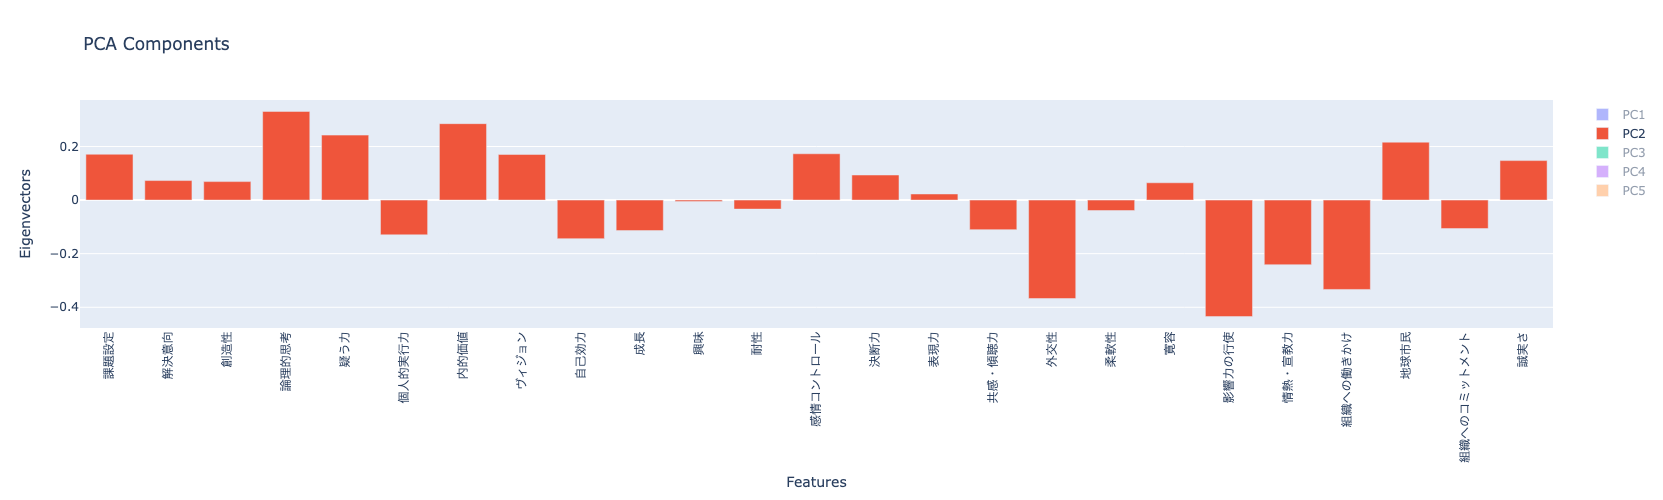

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,SUM_ALL
0,0.16,0.10,0.09,0.07,0.05,0.05,0.04,0.04,0.03,0.03,0.03,0.03,0.03,0.03,0.02,0.82


In [26]:
# 主成分ベクトルの視覚化
def plot_pca_components(components_df):
    fig = go.Figure()
    
    for col in components_df.columns:
        fig.add_trace(go.Bar(
            x=components_df.index,
            y=components_df[col],
            name=col
        ))
    
    fig.update_layout(
        title='PCA Components',
        xaxis_title='Features',
        yaxis_title='Eigenvectors',
        xaxis_tickangle=-90,
        height=500, width=1000
    )
    
    fig.show()

# 可視化の実行
plot_pca_components(tmp.head(5).T)

# 寄与率を求める
df_con_ratio = pd.DataFrame([pca.explained_variance_ratio_], columns=pca_col)
df_con_ratio["SUM_ALL"] = df_con_ratio.sum(axis=1)
display((df_con_ratio.head()))

In [28]:
import joblib

# PCAモデルの保存
joblib.dump(pca, "output/pca_modelp.pkl")

['output/pca_modelp.pkl']

In [29]:
# pca_loaded = joblib.load("output/pca_modelp.pkl")

####################
n_neighbors: 3


/Users/c.yokota/Desktop/igs_data_analisis/python_31014/.venv/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



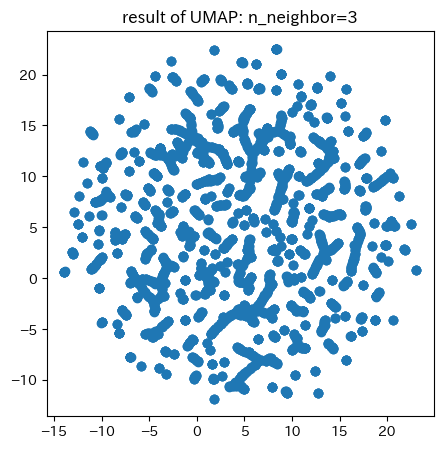

####################
n_neighbors: 4


/Users/c.yokota/Desktop/igs_data_analisis/python_31014/.venv/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



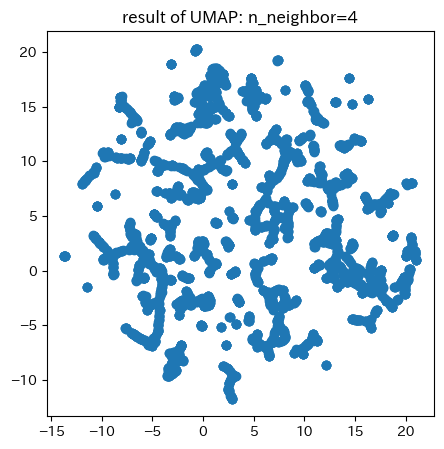

####################
n_neighbors: 5


/Users/c.yokota/Desktop/igs_data_analisis/python_31014/.venv/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



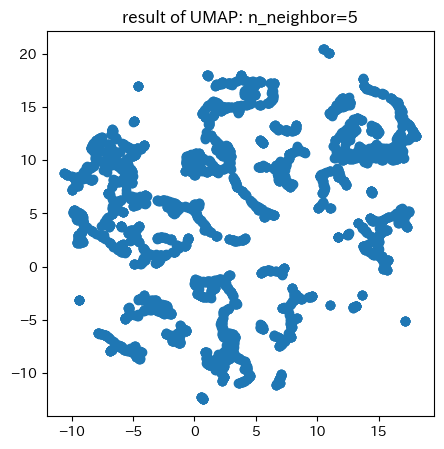

####################
n_neighbors: 6


/Users/c.yokota/Desktop/igs_data_analisis/python_31014/.venv/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

Exception ignored in: <function WeakValueDictionary.__init__.<locals>.remove at 0x30c676a20>
Traceback (most recent call last):
  File "/Users/c.yokota/.pyenv/versions/3.11.9/lib/python3.11/weakref.py", line 105, in remove
    def remove(wr, selfref=ref(self), _atomic_removal=_remove_dead_weakref):

KeyboardInterrupt: 

KeyboardInterrupt



In [21]:
#主成分分析データを使って、クラスタリング
for i in range(3, 25):
    print("#"*20)
    print("n_neighbors:", i)
    # UMAPのハイパーパラメータの選択
    # umap = UMAP(n_components = 2, 
    #             n_neighbors = i, 
    #             min_dist=0.1,
    #             # metric="cosine",
    #             random_state=3)
    umap = UMAP(n_components = 2, 
                n_neighbors = i, 
                min_dist=0.1,
                metric="canberra",
                random_state=3)
    Y = umap.fit_transform(X_reduced.iloc[:, :2])
    plt.figure(figsize = (5, 5))
    plt.scatter(Y[:,0], Y[:,1],)
    plt.title(f"result of UMAP: n_neighbor={i}")
    plt.show()

/Users/c.yokota/Desktop/igs_data_analisis/python_31014/.venv/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



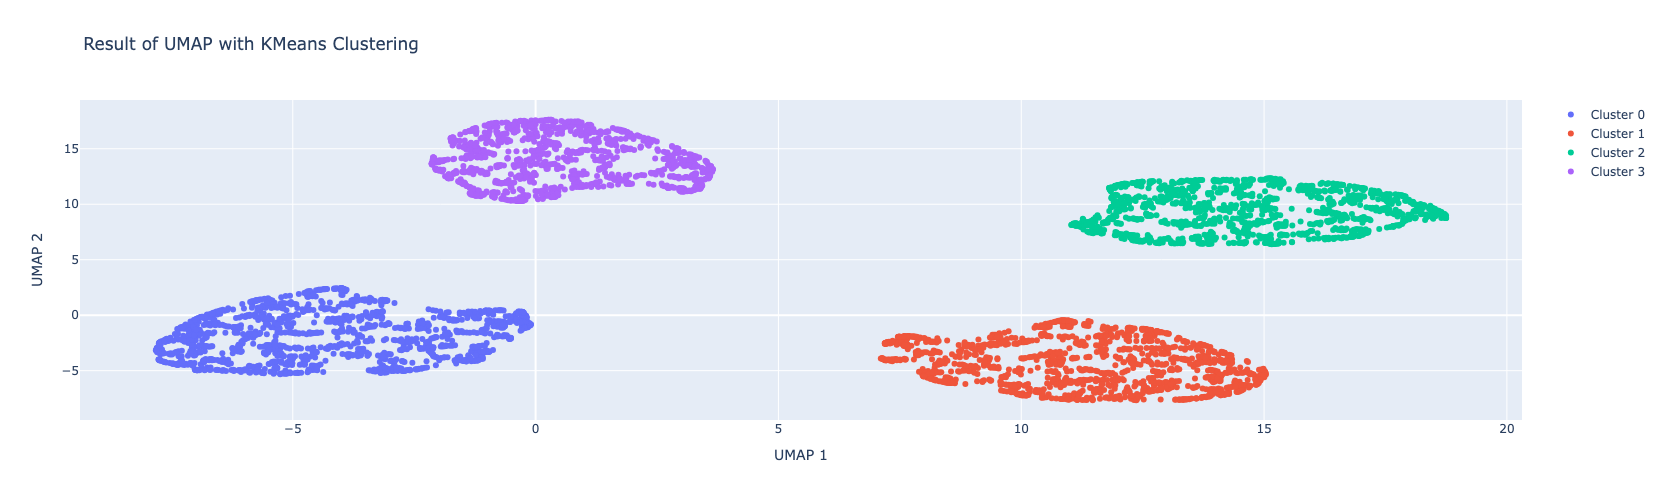

In [30]:
from sklearn.cluster import KMeans

umap = UMAP(n_components = 2, 
                n_neighbors = 17, 
                min_dist=0.1,
                metric="canberra",
                random_state=3)
Y = umap.fit_transform(X_reduced.iloc[:, :2])

# クラスタ数の指定
cluster_num = 4

# KMeans によるクラスタリング
kmeans = KMeans(n_clusters=cluster_num, random_state=0)
cluster = kmeans.fit_predict(Y)

# クラスタ列をYに追加
Y_with_cluster = np.insert(Y, 2, cluster, axis=1)

# プロット準備
plot = []
for i in range(cluster_num):
    Y_selected = Y_with_cluster[Y_with_cluster[:, 2] == i]
    d = go.Scatter(
        x=Y_selected[:, 0],
        y=Y_selected[:, 1],
        mode='markers',
        name=f"Cluster {i}"
    )
    plot.append(d)

# 図のレイアウト
fig = go.Figure(data=plot)
fig.update_layout(
    title="Result of UMAP with KMeans Clustering",
    xaxis_title="UMAP 1",
    yaxis_title="UMAP 2",
    width=500,
    height=500
)

fig.show()

<!-- PC1: (課題設定、論理的思考、解決意向、影響力の行使、自己効力) vs (寛容、感情コントロール、共感傾聴、地球市民)  
PC1が高い人は「課題解決型・リーダーシップタイプ」  
PC1が低い人は「共感・協調型・調整タイプ」  

PC2:  
(外交性, 影響力の行使、情熱・宣教力, 組織への働きかけ) vs (課題設定, 論理的思考,  疑う力, 地球市民, 誠実性)  
【正の方向】  
（外交性, 影響力の行使、情熱・宣教力, 組織への働きかけ）  
→ 外向的で、他者や組織を巻き込んで動かす「発信・推進型」特性  

周囲と積極的に関わりながら、自らの考えや価値観を情熱的に伝える  

組織に対して影響を与える・変えることに積極的  

【負の方向】
（課題設定, 論理的思考, 疑う力, 地球市民, 誠実性）
→ 内省的で、熟慮・探究・価値志向を大事にする「内面的信念型」特性

物事の本質を論理的に掘り下げたり、安易に信じず問い直したりする

誠実に、価値や規範を大切にしながら、自分の軸で行動する

PC3:
(創造性, 個人的実行力、ヴィジョン、自己効力, 成長) vs (外交性, 共感・傾聴力, 影響力の行使, 組織への働きかけ, 誠実さ)
情熱的・直感的か、冷静・論理的か -->

In [31]:
import joblib

# UMAPモデルの保存
joblib.dump(umap, "output/umap_model_canberra.pkl")
joblib.dump(kmeans, "output/kmeans.pkl")

['output/kmeans.pkl']

In [33]:
# 保存したUMAPモデルを読み込む
umap_loaded = joblib.load("output/umap_model_canberra.pkl")

In [34]:
cl_df = ID.with_columns(
    cluster = cluster)

In [35]:
# タイプ①：課題解決・能動タイプ
problem_solving_active = [
    "課題設定",
    "論理的思考",
    "解決意向",
    "影響力の行使",
    "自己効力"
]

# タイプ②：共感・安定タイプ
empathy_stability = [
    "寛容",
    "感情コントロール",
    "共感・傾聴力",
    "地球市民"
]

# タイプ③：情熱・推進タイプ
passion_driver = [
    "外交性",
    "影響力の行使",
    "情熱・宣教力",
    "組織への働きかけ"
]

# タイプ④：冷静・内省タイプ
logic_reflection = [
    "課題設定",
    "論理的思考",
    "疑う力",
    "地球市民",
    "誠実さ"
]

In [36]:
cl_df

Evaluatee Flag ID,ヴィジョン,個人的実行力,共感・傾聴力,内的価値,創造性,地球市民,外交性,寛容,影響力の行使,情熱・宣教力,感情コントロール,成長,柔軟性,決断力,疑う力,組織へのコミットメント,組織への働きかけ,耐性,自己効力,興味,表現力,解決意向,誠実さ,課題設定,論理的思考,cluster
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i32
"""F10004601_4""",48.064419,91.991352,86.031373,48.177747,44.975828,62.987715,77.249456,86.263499,56.609248,63.503921,81.467998,75.152341,71.947192,80.609804,92.202375,72.454249,83.694459,80.584475,56.707467,80.940103,78.040974,89.278867,80.9826,78.405739,78.135851,1
"""F10004606_2""",81.36808,91.996852,79.53408,78.009178,78.36134,84.06384,95.129539,89.153852,74.662366,86.824903,87.434316,87.242903,100.0,90.520911,89.212911,100.0,100.0,96.639316,80.91808,82.332202,82.175951,83.527091,95.171518,82.072202,79.242229,1
"""F10004673_4""",75.0,87.837237,81.592953,70.389799,84.737164,67.506621,85.075875,84.737164,78.351793,75.0,84.737164,78.351793,78.351793,81.592953,84.737164,75.0,75.0,84.737164,81.592953,75.0,75.0,84.737164,75.0,78.351793,84.737164,2
"""F10004676_2""",64.310303,73.641712,56.882237,67.623339,43.701328,66.262057,53.642266,61.017601,77.802508,60.8309,86.101624,58.125465,69.242133,75.985188,67.818286,72.036641,70.360555,70.304743,69.906602,55.69953,55.860594,79.564652,83.588528,76.339135,70.315552,3
"""F10004680_2""",55.30119,69.044198,70.734045,75.638895,48.561311,58.00661,80.162381,87.892283,81.973496,81.612914,53.420364,62.42366,60.31611,66.605619,58.516357,76.403564,78.761392,74.771613,66.254805,52.87541,66.601472,43.161823,90.245955,59.709687,56.330517,2
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""F10020509_15""",59.759372,58.550827,56.398691,43.532885,41.40098,57.037038,70.958611,64.76468,46.160763,67.567583,52.787825,60.556144,62.617439,52.287431,46.312763,67.669583,72.893955,53.646468,46.152905,57.653421,51.351539,69.579588,65.561947,59.389263,52.713135,1
"""F10020510_15""",74.722222,66.091716,50.606638,66.990388,57.918677,53.085806,74.166667,59.302455,47.001113,66.655988,70.621173,66.135716,58.192011,69.788728,39.888632,74.534674,58.602677,74.583333,62.749591,70.289582,54.036203,61.737309,73.283435,71.960355,50.005749,2
"""F10020511_15""",65.02425,72.553217,80.330793,79.648268,72.889167,69.343007,83.054648,78.744575,61.871509,80.974671,83.098648,69.923951,69.693951,80.168793,69.483951,72.232056,74.117582,79.47413,66.004695,73.402249,70.150563,65.963689,72.140056,74.377436,72.716279,0


In [37]:
cl_df = cl_df.with_columns(
    pl.mean_horizontal(empathy_stability).alias("協調・共感平均"),
    pl.mean_horizontal(problem_solving_active).alias("課題志向平均"),
    pl.mean_horizontal(passion_driver).alias("情熱・推進平均"),
    pl.mean_horizontal(logic_reflection).alias("冷静・論理平均"),
)

In [39]:
cl_df.group_by(
    "cluster"
).agg(
   pl.mean(["協調・共感平均", "課題志向平均", "情熱・推進平均", "冷静・論理平均"])
)

cluster,協調・共感平均,課題志向平均,情熱・推進平均,冷静・論理平均
i32,f64,f64,f64,f64
0,70.520398,56.377252,57.536114,63.835348
1,74.466475,62.182209,70.346655,65.309102
2,73.188655,77.795089,80.027359,74.806799
3,67.167338,70.83063,64.948435,72.730989


In [30]:
0: 協調, 冷静
1: 協調, 情熱
2: 課題, 情熱
3: 課題, 冷静

SyntaxError: illegal target for annotation (1858238629.py, line 1)

In [31]:
data = [
    {
        "タイプ名": "突破型",
        "重視軸": "タスク重視",
        "スタンス軸": "情熱的",
        "主なコンピテンシー": "課題設定, 論理的思考, 解決意向, 影響力の行使, 自己効力, 外交性, 情熱・宣教力, 組織への働きかけ",
        "特徴": "強い意志と熱量で課題を突破する推進型。周囲を巻き込みながら成果を出す。"
    },
    {
        "タイプ名": "巻き込み型",
        "重視軸": "人間関係重視",
        "スタンス軸": "情熱的",
        "主なコンピテンシー": "寛容, 感情コントロール, 共感・傾聴力, 地球市民, 外交性, 影響力の行使, 情熱・宣教力, 組織への働きかけ",
        "特徴": "人の心を動かし、チームや場を熱量で動かす共感型。巻き込み力が高い。"
    },
    {
        "タイプ名": "構築型",
        "重視軸": "タスク重視",
        "スタンス軸": "冷静",
        "主なコンピテンシー": "課題設定, 論理的思考, 解決意向, 自己効力, 疑う力, 地球市民, 誠実性",
        "特徴": "冷静に課題を整理・構造化し、着実に成果を出す。仕組みづくりに強い。"
    },
    {
        "タイプ名": "支援型",
        "重視軸": "人間関係重視",
        "スタンス軸": "冷静",
        "主なコンピテンシー": "寛容, 感情コントロール, 共感・傾聴力, 地球市民, 誠実性",
        "特徴": "穏やかに人と場を整える調整役。配慮と安定感で信頼を集める。"
    }
]

In [70]:
# 重視軸とスタンス軸それぞれに対応するコンピテンシーのデータフレームを作成

重視軸_data = [
    {
        "軸名": "重視軸",
        "区分": "タスク重視",
        "関連コンピテンシー": "課題設定, 論理的思考, 解決意向, 影響力の行使, 自己効力",
        "説明": "成果・課題解決に関心が高く、目的達成に向けて論理的に行動する傾向。"
    },
    {
        "軸名": "重視軸",
        "区分": "人間関係重視",
        "関連コンピテンシー": "寛容, 感情コントロール, 共感傾聴, 地球市民",
        "説明": "人や場の調和に関心が高く、共感や多様性への配慮を重視して行動する傾向。"
    }
]

スタンス軸_data = [
    {
        "軸名": "スタンス軸",
        "区分": "情熱的",
        "関連コンピテンシー": "外交性, 影響力の行使, 情熱・宣教力, 組織への働きかけ",
        "説明": "熱量を持って周囲に働きかけ、エネルギッシュに動く傾向。巻き込みや牽引が得意。"
    },
    {
        "軸名": "スタンス軸",
        "区分": "冷静",
        "関連コンピテンシー": "課題設定, 論理的思考, 疑う力, 地球市民, 誠実性",
        "説明": "落ち着いて物事を捉え、筋の通った判断や安定した行動を取る傾向。"
    }
]

df_axes = pd.DataFrame(重視軸_data + スタンス軸_data)

